<a href="https://colab.research.google.com/github/DBasnet167/CIND-820-Project/blob/main/Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Step 1: Data Loading and Initial Filtering ---


/tmp/ipython-input-7-846316031.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["REF_DATE"] = pd.to_datetime(df["REF_DATE"], format="%Y-%m")


Initial CPI data loaded. Shape: (121, 1)
First 5 rows of CPI data:
              cpi
date             
2015-01-01  124.3
2015-02-01  125.4
2015-03-01  126.3
2015-04-01  126.2
2015-05-01  126.9

--- Step 2: Log-transform and Differencing ---
Log-differenced CPI (inflation) series created. Shape: (120, 3)
First 5 rows of log_diff:
date
2015-02-01    0.008811
2015-03-01    0.007151
2015-04-01   -0.000792
2015-05-01    0.005531
2015-06-01    0.002361
Freq: MS, Name: log_diff, dtype: float64

--- Step 3: Comprehensive Feature Engineering ---
Dropped 12 rows due to NaN values from feature engineering.
DataFrame shape after all feature engineering and dropna: (108, 23)
Data starts from: 2016-02

--- Step 4: Feature Standardization ---
Shape of X (features): (108, 20)
Shape of y (target): (108,)

Sample of X (features) head after full engineering and scaling:
               lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
date                                                          

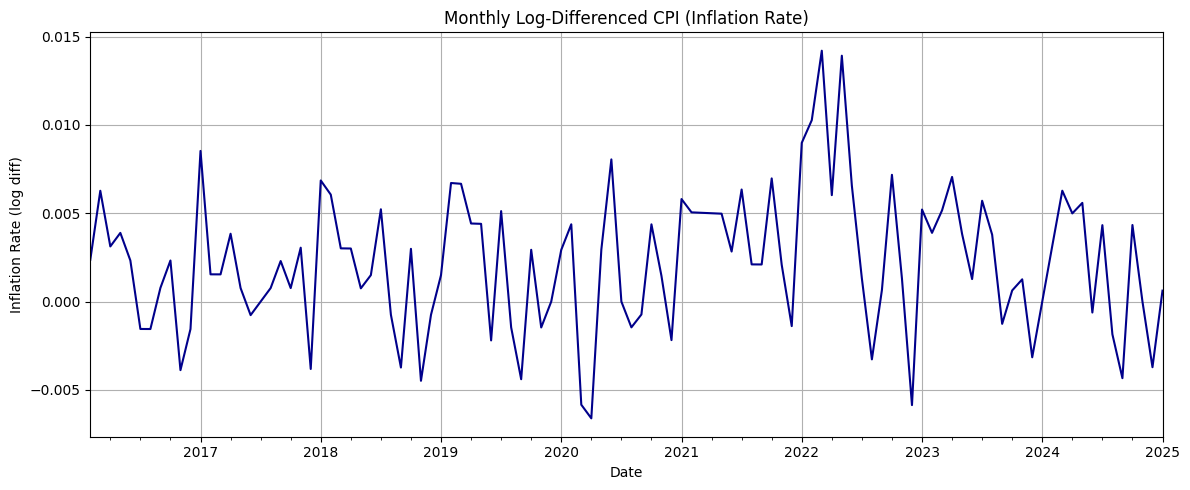

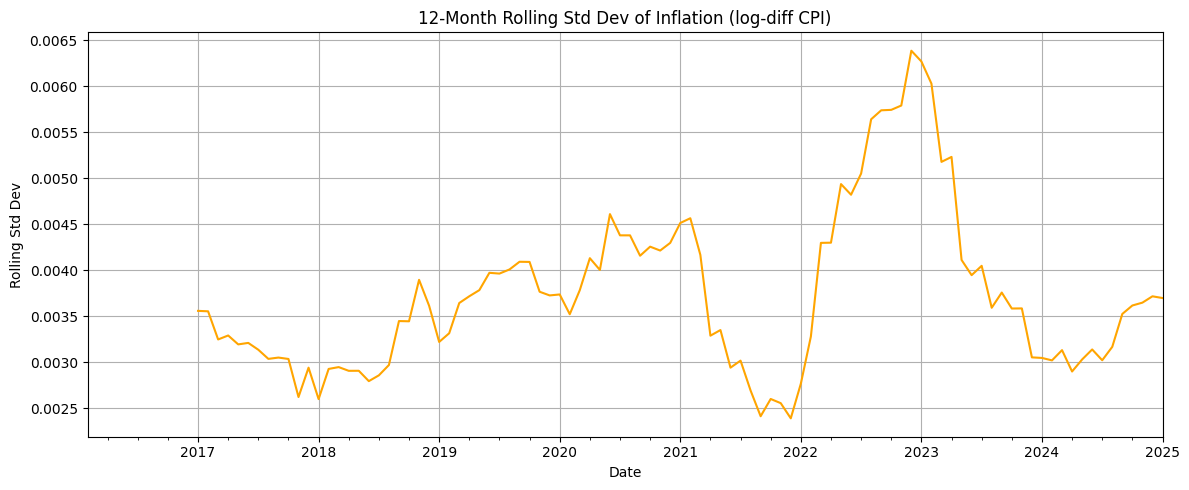

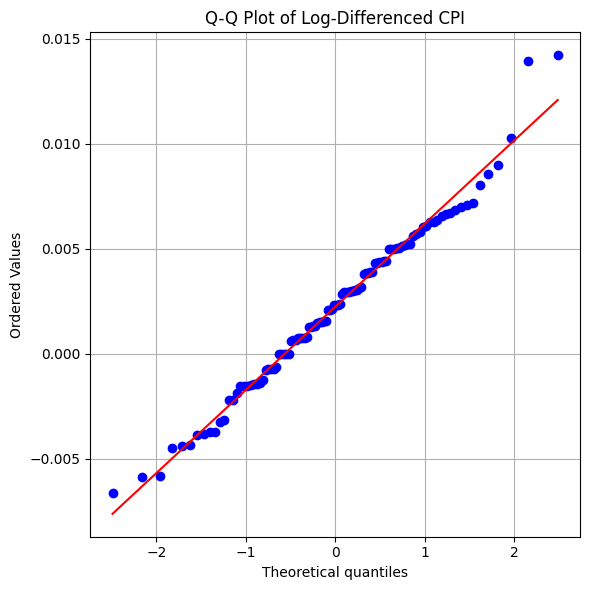

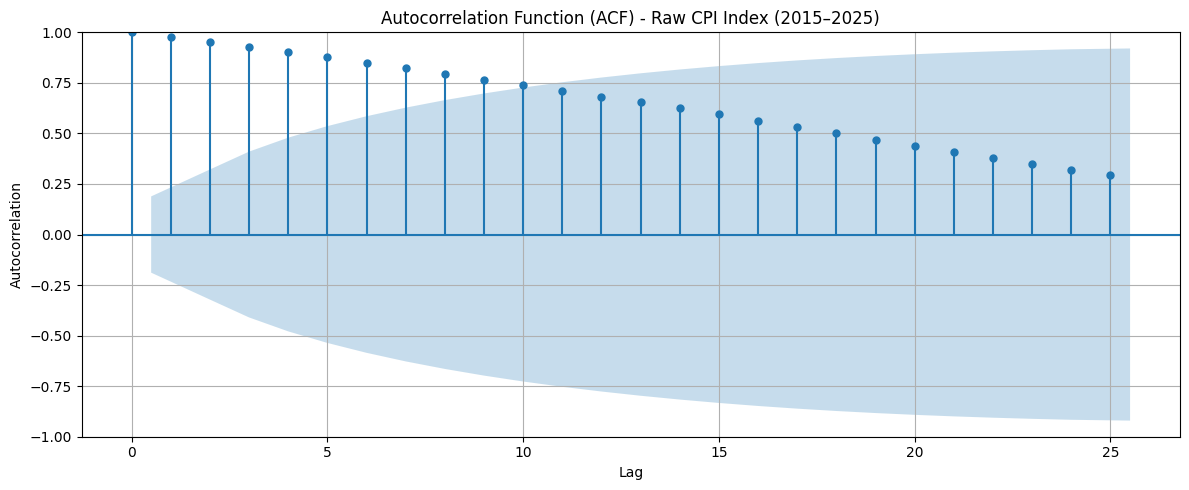

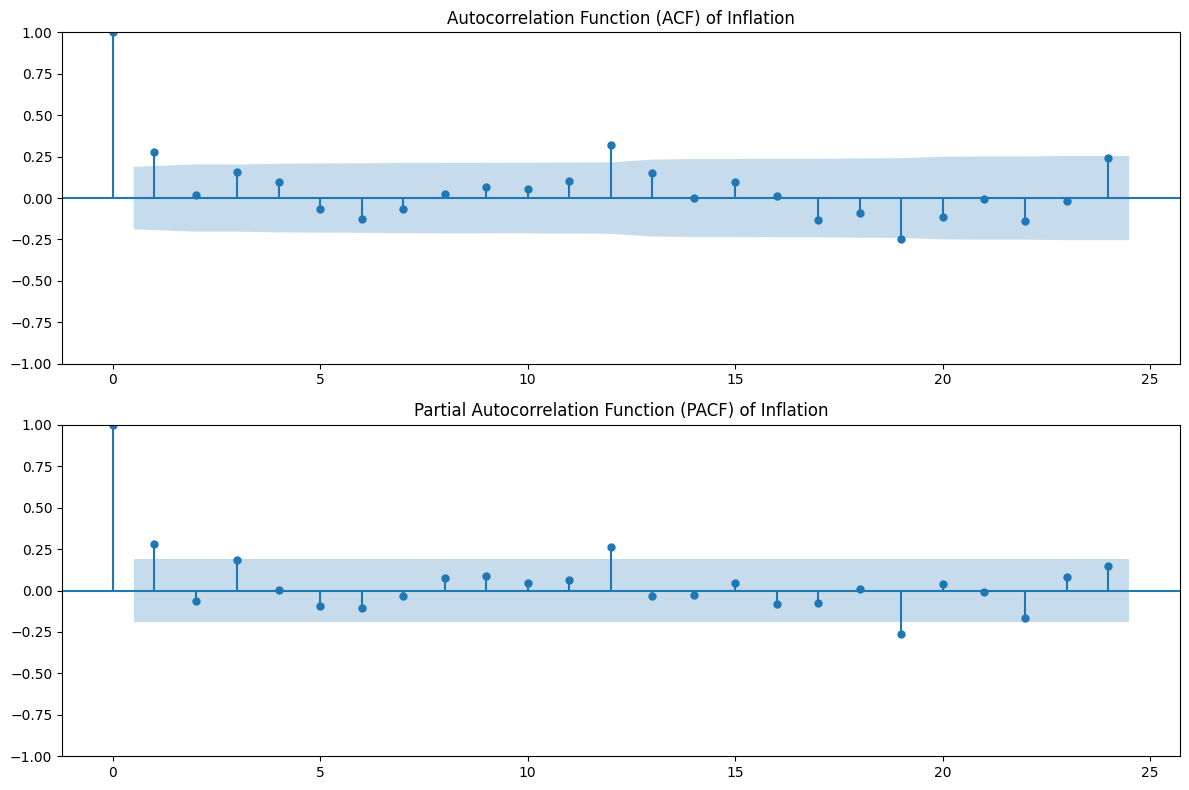


--- Augmented Dickey-Fuller Test Results (for log_diff) ---
ADF Statistic: -7.678132920403302
p-value: 1.5292643797126372e-11
Number of Lags Used: 0
Number of Observations Used: 107
Critical Values:
	1%: -3.492995948509562
	5%: -2.888954648057252
	10%: -2.58139291903223

Conclusion: The p-value is <= 0.05. We reject the null hypothesis.
This suggests that the Monthly Log-Differenced CPI (Inflation Rate) series is stationary.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Often used for plots, good to include
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import probplot # For Q-Q plot

# --- 1. Data Loading and Initial Filtering ---
print("--- Step 1: Data Loading and Initial Filtering ---")
df = pd.read_csv("18100004.csv", low_memory=False)

df = df[
    (df["GEO"] == "Canada") &
    (df["Products and product groups"] == "All-items") &
    (df["UOM"] == "2002=100")
]

df["REF_DATE"] = pd.to_datetime(df["REF_DATE"], format="%Y-%m")
df = df[(df["REF_DATE"] >= "2015-01-01") & (df["REF_DATE"] <= "2025-01-31")]
df = df[["REF_DATE", "VALUE"]].rename(columns={"REF_DATE": "date", "VALUE": "cpi"})
df.set_index("date", inplace=True)
df = df.asfreq("MS") # Ensure monthly frequency

print(f"Initial CPI data loaded. Shape: {df.shape}")
print("First 5 rows of CPI data:")
print(df.head())

# --- 2. Log-transform and Differencing (Inflation Series Creation) ---
print("\n--- Step 2: Log-transform and Differencing ---")
df["log_cpi"] = np.log(df["cpi"])
df["log_diff"] = df["log_cpi"].diff() # This is our target variable: monthly inflation
# Drop the first NaN from differencing
df.dropna(subset=['log_diff'], inplace=True)

print(f"Log-differenced CPI (inflation) series created. Shape: {df.shape}")
print("First 5 rows of log_diff:")
print(df['log_diff'].head())

# --- 3. Comprehensive Feature Engineering (All features lagged to prevent leakage) ---
print("\n--- Step 3: Comprehensive Feature Engineering ---")

# Add lag features (up to 12 months, starting from lag_1)
for lag in range(1, 13):
    df[f'lag_{lag}'] = df['log_diff'].shift(lag)

# Add rolling mean features (all shifted by 1 to prevent data leakage)
df['rolling_mean_3_lag1'] = df['log_diff'].rolling(window=3).mean().shift(1)
df['rolling_mean_6_lag1'] = df['log_diff'].rolling(window=6).mean().shift(1)
df['rolling_mean_12_lag1'] = df['log_diff'].rolling(window=12).mean().shift(1)

# Add rolling standard deviation features (all shifted by 1 to prevent data leakage)
df['rolling_std_3_lag1'] = df['log_diff'].rolling(window=3).std().shift(1)
df['rolling_std_6_lag1'] = df['log_diff'].rolling(window=6).std().shift(1)
df['rolling_std_12_lag1'] = df['log_diff'].rolling(window=12).std().shift(1)

# Fourier terms for seasonality (period = 12 months)
# Ensure 't' aligns with the current df index after prior dropna
t = np.arange(len(df.index))
df['sin_12'] = np.sin(2 * np.pi * t / 12)
df['cos_12'] = np.cos(2 * np.pi * t / 12)

# Drop any remaining rows with NaN values introduced by lagging/rolling operations
# This is crucial for the start date of your final dataset
initial_rows = df.shape[0]
df.dropna(inplace=True)
final_rows = df.shape[0]
print(f"Dropped {initial_rows - final_rows} rows due to NaN values from feature engineering.")
print(f"DataFrame shape after all feature engineering and dropna: {df.shape}")
print(f"Data starts from: {df.index.min().strftime('%Y-%m')}") # Should be 2016-02

# Define all features that will be used for training dynamically
features = [col for col in df.columns if col.startswith('lag_') or \
            col.startswith('rolling_mean_') or \
            col.startswith('rolling_std_') or \
            col in ['sin_12', 'cos_12']]

# --- 4. Feature Standardization ---
print("\n--- Step 4: Feature Standardization ---")
scaler = StandardScaler()
df_scaled = df.copy() # Work on a copy to keep original for target
df_scaled[features] = scaler.fit_transform(df_scaled[features])

X = df_scaled[features] # Features for training
y = df["log_diff"]      # Target variable (original, unscaled log_diff)

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")
print("\nSample of X (features) head after full engineering and scaling:")
print(X.head())
print("\nSample of y (target) head:")
print(y.head())

# --- 5. Train-Test Split (Last 24 months as test set) ---
print("\n--- Step 5: Train-Test Split ---")
test_set_size = 24
train_size = len(X) - test_set_size
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training set size: {len(X_train)} samples ({y_train.index.min().strftime('%Y-%m')} to {y_train.index.max().strftime('%Y-%m')})")
print(f"Testing set size: {len(X_test)} samples ({y_test.index.min().strftime('%Y-%m')} to {y_test.index.max().strftime('%Y-%m')})")

# --- 6. Stationarity and Distribution Analysis Plots & Tests ---
print("\n--- Step 6: Stationarity and Distribution Analysis ---")

# Plot monthly inflation rate
plt.figure(figsize=(12, 5))
df['log_diff'].plot(title="Monthly Log-Differenced CPI (Inflation Rate)", color='darkblue')
plt.ylabel("Inflation Rate (log diff)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 12-month rolling standard deviation of inflation
df["rolling_std_12_plot"] = df["log_diff"].rolling(window=12).std() # A temporary column for plotting
plt.figure(figsize=(12, 5))
df["rolling_std_12_plot"].plot(color="orange", title="12-Month Rolling Std Dev of Inflation (log-diff CPI)")
plt.ylabel("Rolling Std Dev")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()
df.drop(columns=['rolling_std_12_plot'], inplace=True) # Clean up temporary column

# Q-Q plot for normality check
plt.figure(figsize=(6, 6))
probplot(df['log_diff'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Differenced CPI")
plt.grid(True)
plt.tight_layout()
plt.show()

# ACF for Raw CPI Index (Non-stationarity check)
raw_cpi = df['cpi'].dropna() # Use original cpi from df
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(raw_cpi, lags=25, alpha=0.05, ax=ax)
plt.title("Autocorrelation Function (ACF) - Raw CPI Index (2015–2025)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.grid(True)
plt.show()

# ACF and PACF for the inflation series (log_diff)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['log_diff'], lags=24, ax=axes[0], title='Autocorrelation Function (ACF) of Inflation')
plot_pacf(df['log_diff'], lags=24, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Inflation', method='ywm') # 'ywm' or 'ols'
plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller (ADF) Test for Stationarity
print("\n--- Augmented Dickey-Fuller Test Results (for log_diff) ---")
adf_test_result = adfuller(df['log_diff'])

print('ADF Statistic:', adf_test_result[0])
print('p-value:', adf_test_result[1])
print('Number of Lags Used:', adf_test_result[2])
print('Number of Observations Used:', adf_test_result[3])
print('Critical Values:')
for key, value in adf_test_result[4].items():
    print(f'\t{key}: {value}')

if adf_test_result[1] <= 0.05:
    print("\nConclusion: The p-value is <= 0.05. We reject the null hypothesis.")
    print("This suggests that the Monthly Log-Differenced CPI (Inflation Rate) series is stationary.")
else:
    print("\nConclusion: The p-value is > 0.05. We fail to reject the null hypothesis.")
    print("This suggests that the Monthly Log-Differenced CPI (Inflation Rate) series is likely non-stationary.")